# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Advanced Topics in Data Science

## **Transfer Learning using WAV2VEC2.0**


**Harvard University**<br/>
**Spring 2024**<br/>
**Instructors**: Pavlos Protopapas<br/>
**Project Members**: Elianne Sacher, Shane Kissinger, and Oleg Pavliv

In [1]:
# RUN THIS CELL
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

In [2]:
# Import libraries
import time
start_time = time.time() 
import requests
import zipfile
import io, os
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import scipy as sp

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import sklearn as sk

from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, Activation, BatchNormalization, Flatten, Dropout, GaussianNoise, RandomContrast, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

from PIL import Image
from io import BytesIO

import torch
import torchaudio
import soundfile as sf
from torchaudio.transforms import Resample
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, Wav2Vec2Processor, TrainingArguments, Trainer
from sklearn.preprocessing import LabelEncoder

import evaluate
from tqdm import tqdm
import gc  # Garbage collection module
import re  # Regular expressions for text processing
tqdm.pandas()

from sklearn.utils.class_weight import compute_class_weight
from datasets import concatenate_datasets, Dataset, load_dataset, Image, ClassLabel, load_from_disk, DatasetDict

import torch.nn as nn
import itertools
import shutil
import librosa

from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix, classification_report, f1_score)

import warnings
# Suppress specific FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore")

2024-05-08 15:07:05.011128: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-08 15:07:05.056676: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 15:07:05.056711: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 15:07:05.057835: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-08 15:07:05.065139: I tensorflow/core/platform/cpu_feature_guar

### Preprocessing and audio sample download

In [3]:
# Previous checkpoints to clear 
folder_paths = ['./mlruns', './bird_sounds_classification']

# Iterate through the list of folder paths
for folder_path in folder_paths:
    try:
        # Check if the directory exists
        if os.path.exists(folder_path):
            # Remove the directory and all its contents
            shutil.rmtree(folder_path)
            print(f"Folder '{folder_path}' has been deleted.")
        else:
            print(f"Folder '{folder_path}' does not exist.")
    except Exception as e:
        print(f"Failed to delete '{folder_path}'. Error: {e}")

Folder './mlruns' does not exist.
Folder './bird_sounds_classification' does not exist.


In [4]:
# Load df_merged_clean from directory if needed 
if 'df_merged_clean' not in locals():
    df_merged_clean = pd.read_csv("merged_clean.csv")

In [5]:
species_list = ["Parus major", "Phylloscopus collybita", "Cyanistes caeruleus", "Passer montanus", "Fringilla coelebs", "Passer domesticus", "Erithacus rubecula", "Aegithalos caudatus", "Strix aluco", "Corvus corax"]  
species_dfs = [df_merged_clean[df_merged_clean["species"] == species_list[i]] for i in range(len(species_list))]

In [6]:

# Downloads specified number of files per class
def download_mp3(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.content
    else:
        return None

def download_species(df, species_class, max_files=20):
    folder_path = f"./sounds/{species_class}/"
    os.makedirs(folder_path, exist_ok=True)  # Ensure the directory exists
    current_sounds = set(os.listdir(folder_path))
    download_count = 0
    
    for i, row in df.iterrows():
        if download_count >= max_files:
            break  # Stop downloading after reaching the max_files limit
        
        url = row["identifier"]
        gbifID = row["gbifID"]
        sound_name = f"{gbifID}.mp3"
        
        if sound_name in current_sounds:
            continue
        
        try:
            sound = download_mp3(url)
        except Exception as e:
            print(f"species class: {species_class} count: {download_count} gbifID: {gbifID} | failed downloading due to {e}")
            continue
    
        if sound is None:
            print(f"species class: {species_class} count: {download_count} gbifID: {gbifID} | download returned None")
            continue
    
        save_path = os.path.join(folder_path, sound_name)
        with open(save_path, 'wb') as f:
            f.write(sound)
        print(f"species class: {species_class} count: {download_count} gbifID: {gbifID} | downloaded")
        download_count += 1

# # Execute downloads
# for i in range(len(species_list)):
#     download_species(species_dfs[i], i, 700)


## Transfer Learning Model Using WAV2VEC2

### Description

Wav2Vec 2.0 is a self-supervised learning framework for speech recognition developed by Facebook AI, which learns powerful representations from raw audio data by capturing contextual information from speech. Here I will use it as a model for a pipeline utilizing a transformers.trainer module to get sufficient accuracy, while limiting the number of whole mp3 files per class to conserve compute.

### Processing for transfer learning 
In order to use transfer learning model WAV2VEC2, paths to mp3 files will be loaded to df along with their respective labels. The will be translated to Pytorch dataset, which will hold each actual numpy array representing the audio file and its class label. Torch tensor will be used as a storage format. Data is pre-processed to ensure 16 kHz sample frequency and librosa's silent threshold is used to get rid of silent segments with 25dB bellow peak sensitivity. 

In [7]:
# Setting number of audiofiles to be segmented #150
num_files_per_folder = 250 

# Constants for resampling and segment length 
RATE_HZ = 16000
MAX_SECONDS = 10
MAX_LENGTH = RATE_HZ * MAX_SECONDS

# Function to load audio and filter out silent intervals
def load_and_filter_audio(mp3_path, silence_threshold=25):
    # Load the audio file
    y, sr = librosa.load(mp3_path, sr=None)  # Load with the native sampling rate

    # Detect non-silent intervals based on the threshold
    non_silent_intervals = librosa.effects.split(y, top_db=silence_threshold)

    # Concatenate non-silent intervals into a single array
    filtered_audio = np.concatenate([y[start:end] for start, end in non_silent_intervals])

    # Convert numpy array back to torch tensor
    filtered_audio = torch.from_numpy(filtered_audio).float()

    return filtered_audio, sr

# Load and process audio using PyTorch
def load_and_process_audio(directory, label, max_files=None):
    files = os.listdir(directory)
    if max_files is not None:
        files = files[:max_files]  # Limit the number of files to process
    df_list = []

    for file in tqdm(files):
        if file.endswith('.mp3'):
            file_path = os.path.join(directory, file)
            try:
                # Load and filter the audio to remove silence
                audio, rate = load_and_filter_audio(file_path)
                
                # Check if any audio is left after filtering silence
                if audio.size == 0:
                    print(f"No audio left after filtering silence in file: {file_path}")
                    continue
                
                # Resample if needed
                if rate != RATE_HZ:
                    transform = torchaudio.transforms.Resample(rate, RATE_HZ)
                    audio = transform(audio)
                
                
                audio, rate = torchaudio.load(file_path)
                num_segments = len(audio[0]) // MAX_LENGTH
                segmented_audio = []

                for i in range(num_segments):
                    start = i * MAX_LENGTH
                    end = min((i + 1) * MAX_LENGTH, len(audio[0]))
                    segment = audio[0][start:end]
                    transform = torchaudio.transforms.Resample(rate, RATE_HZ)
                    segment = transform(segment).squeeze(0).numpy().reshape(-1)
                    segmented_audio.append(segment)

                if segmented_audio:
                    df_segments = pd.DataFrame({'audio': segmented_audio, 'label': [label] * len(segmented_audio)})
                    df_list.append(df_segments)
                    gc.collect()
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

    return pd.concat(df_list, axis=0) if df_list else pd.DataFrame()

base_folder = "./sounds"
all_species_dfs = []

# for label in range(10): 
#     directory_path = os.path.join(base_folder, str(label))
#     if os.path.isdir(directory_path):
#         species_df = load_and_process_audio(directory_path, label, max_files=num_files_per_folder)
#         all_species_dfs.append(species_df)

# # Create a single DataFrame to prepare for port to PyTorch dataset
# df = pd.concat(all_species_dfs, axis=0)
# print(df.sample(5))

# Clears carbage from memory
gc.collect()

120

We truncated the dataframe to 3000 segments per class to balance accuracy with conserving computational resources and speed. 

In [8]:
# # Selecting rows in the DataFrame where the 'audio' column is not null
# df = df[~df['audio'].isnull()]

# print("class counts before truncation:\n") 
# print(df.groupby('label').size())

# # Limiting to a specific nummber of segments per class
# truncated_df = df.groupby('label').head(3000)
# df = truncated_df
# print("class counts after truncation:\n") 
# print(df.groupby('label').size())

In [9]:
# # Mapping and replacing from numeric labels back to species names
# label_to_species = {i: name for i, name in enumerate(species_list)}
# df['label'] = df['label'].replace(label_to_species)

# # Sample from the updated DataFrame to verify changes
# print(df.sample(5))

The progress was restarted from a checkpoint due to kernel instability. 

In [10]:
# Checkpoint
# df.to_csv("audio_processed_metadata.csv", index=False)
df = pd.read_csv("audio_processed_metadata.csv")

In [11]:
print("class counts after truncation:\n\n") 
print(df.groupby('label').size())

class counts after truncation:


label
Aegithalos caudatus       3000
Corvus corax              3000
Cyanistes caeruleus       3000
Erithacus rubecula        3000
Fringilla coelebs         3000
Parus major               3000
Passer domesticus         3000
Passer montanus           3000
Phylloscopus collybita    3000
Strix aluco               3000
dtype: int64


In [12]:
# Port to dataset in chunks to save memory
gc.collect()
chunk_size = 100
datasets = []
for i in range(0, len(df), chunk_size):
    chunk_dataset = Dataset.from_pandas(df.iloc[i:i + chunk_size])
    datasets.append(chunk_dataset)
    gc.collect()

# Concatenating all the datasets into one
dataset = concatenate_datasets(datasets)

### Handing class imbalance 

While undersampling overweight classes is a method we selected in this pipeline, we would like to simulate running the model on a complete database in which case not using available data would be suboptimal. Therefore, we included robust way to handle class imbalance in future use of this pipeline. The function compute_class_weight from a scikit-learn library is used here with the parameter class_weight='balanced'. This function calculates weights for each class such that smaller classes get a higher weight and larger classes get a lower weight. The formula typically used ensures that each class contributes equally to the model's loss during training, thus compensating for imbalances in the dataset.

The weights are then taken into account as an imput to torch.nn crossentropy function to adjust the weight of each sample during the training. 

In [13]:
classes = np.unique(df[['label']])

weights = compute_class_weight(class_weight='balanced', classes=classes, y=df['label'])

# Create a dictionary mapping each class to its respective class weight.
class_weights = dict(zip(classes, weights))

# Print the computed class weights to the console.
print(class_weights)

{'Aegithalos caudatus': 1.0, 'Corvus corax': 1.0, 'Cyanistes caeruleus': 1.0, 'Erithacus rubecula': 1.0, 'Fringilla coelebs': 1.0, 'Parus major': 1.0, 'Passer domesticus': 1.0, 'Passer montanus': 1.0, 'Phylloscopus collybita': 1.0, 'Strix aluco': 1.0}


In [14]:
# Create a list of unique labels
labels_list = sorted(list(df['label'].unique()))

# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

Bellow, we create ClassLabels to be used by the trainer and split PyTorch dataset into 0.1 train-test split.

In [15]:
# Creating classlabels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

gc.collect()

dataset = dataset.map(map_label2id, batched=True, batch_size=32, writer_batch_size=32, cache_file_name='mapped_dataset')


# Casting label column to ClassLabel Object
dataset = dataset.cast_column('label', ClassLabels)

# Define the fraction of records to be used for testing data
TEST_SIZE = 0.1

# Splitting the dataset into training and testing sets using the predefined train/test split ratio.
dataset = dataset.train_test_split(test_size=TEST_SIZE, shuffle=True, stratify_by_column="label")

Casting the dataset:   0%|          | 0/19612 [00:00<?, ? examples/s]

We use Wav2vec2 model with pre-trained weights that we will subsequently fine-tune. Feature extractor is also specified. AutoFeatureExtractor is part of the Hugging Face Transformers library. It's used to automatically select the appropriate feature extractor for a given pretrained model based on the model's architecture. This feature extractor is responsible for converting the audio signals into a format that the model can process. For example, in the context of Wav2Vec 2.0, the feature extractor handles tasks such as sampling rate conversion and audio normalization.The method .from_pretrained(model_str) initializes the feature extractor with the configuration that was used during the training of the model specified by model_str. This ensures that the input to the model is processed in exactly the same way as it was during training. 

In [16]:
# Specify the pre-trained model you want to use.
model_str ="facebook/wav2vec2-base-960h" #"facebook/wav2vec2-base-960h"

# Create an instance of the feature extractor for audio.
feature_extractor = AutoFeatureExtractor.from_pretrained(model_str)

# Create an instance of the audio classification model.
# The 'num_labels' parameter is set to the number of labels in your 'labels_list'.
model = AutoModelForAudioClassification.from_pretrained(model_str, num_labels=len(labels_list))

# Set the 'id2label' mapping in the model's configuration. This maps label IDs to human-readable labels.
model.config.id2label = id2label

# Calculate and print the number of trainable parameters in the model (in millions).
# This provides an estimate of the model's size.
print(model.num_parameters(only_trainable=True) / 1e6)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForSequenceClassification: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'projector.bias', 'classifier.weight', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be 

94.571146


Bellow, the preprocessing function is defined using a feature extractor. The preprocessing function is then applied to both the 'train' and 'test' splits of a dataset, removing the original 'audio' column, thereby preparing the data for input into a machine learning model, ensuring it is batched appropriately to optimize processing efficiency.

In [17]:
# Define a preprocessing function for the dataset
def preprocess_function(batch):
    # Extract audio features from the input batch using the feature_extractor
    inputs = feature_extractor(batch['audio'], sampling_rate=RATE_HZ, max_length=MAX_LENGTH, truncation=True)
    
    # Extract and store only the 'input_values' component from the extracted features
    inputs['input_values'] = inputs['input_values'][0]
    return inputs

# Apply the preprocess_function to the 'train' split of the dataset, removing the 'audio' column
dataset['train'] = dataset['train'].map(preprocess_function, remove_columns="audio", batched=False, batch_size=32, writer_batch_size=32)

# Apply the same preprocess_function to the 'test' split of the dataset, removing the 'audio' column
dataset['test'] = dataset['test'].map(preprocess_function, remove_columns="audio", batched=False, batch_size=32, writer_batch_size=32)

Map:   0%|          | 0/17650 [00:00<?, ? examples/s]

Map:   0%|          | 0/1962 [00:00<?, ? examples/s]

In [18]:
# Load the "accuracy" metric using the evaluate.load() function.
accuracy = evaluate.load("accuracy")

# Define a function to compute evaluation metrics, which takes eval_pred as input.
def compute_metrics(eval_pred):
    # Extract the model's predictions from eval_pred.
    predictions = eval_pred.predictions
    
    # Apply the softmax function to convert prediction scores into probabilities.
    predictions = np.exp(predictions) / np.exp(predictions).sum(axis=1, keepdims=True)
    
    # Extract the true label IDs from eval_pred.
    label_ids = eval_pred.label_ids
    
    # Calculate accuracy using the loaded accuracy metric by comparing predicted classes
    # (argmax of probabilities) with the true label IDs.
    acc_score = accuracy.compute(predictions=predictions.argmax(axis=1), references=label_ids)['accuracy']
    
    # Return the computed accuracy as a dictionary with a key "accuracy."
    return {
        "accuracy": acc_score
    }

### Model hyperparameters and configuration
Here we will discuss our reasoning behind the chosen hyperparameters. The batch size of 4 balances the need to save memory, which is especially significant considering the size of WAV2VEC2 with 94 mil parameters, while processing enough data to update the model effectively. Warmup steps set at 50 help the model start learning gradually by increasing the learning rate slowly at the beginning, which helps in avoiding early mistakes that could derail the training process. The weight decay of 0.02 helps prevent the model from relying too heavily on any single or small group of features, which can lead to overfitting, where the model performs well on training data but poorly on unseen data. 7 training epochs provide a reasonable amount of learning cycles to train sufficiently without spending too much time going over the same data repeatedly.

The TrainingArguments configuration is designed to keep a close watch on how the model trains, with detailed logging and evaluation after every epoch to monitor progress and make adjustments if necessary. Features like gradient accumulation and checkpointing help manage memory better and ensure training doesn’t have to start over from scratch after a pause or interruption. Reporting to MLflow is set up to keep track of different training experiments, which is helpful for comparing and analyzing different training settings. Finally, the CustomTrainer is important for managing data imbalance—where some bird sounds might be rarer than others—by adjusting the importance given to each type during training, ensuring a fair learning process.

In [19]:
# Define the batch size for training data
batch_size = 4

# Define the number of warmup steps for learning rate scheduling
warmup_steps = 50

# Define the weight decay for regularization
weight_decay = 0.02

# Define the number of training epochs
num_train_epochs = 12

# Define the name for the model directory
model_name = "bird_sounds_classification"

# Create TrainingArguments object to configure the training process
training_args = TrainingArguments(
    output_dir=model_name,  # Directory to save the model
    logging_dir='./logs',  # Directory for training logs
    num_train_epochs=num_train_epochs,  # Number of training epochs
    per_device_train_batch_size=batch_size,  # Batch size for training
    per_device_eval_batch_size=batch_size,  # Batch size for evaluation
    learning_rate=3e-6,  # Learning rate for training
    logging_strategy='steps',  # Log at specified steps
    logging_first_step=True,  # Log the first step
    load_best_model_at_end=True,  # Load the best model at the end of training
    logging_steps=1,  # Log every step
    evaluation_strategy='epoch',  # Evaluate at the end of each epoch
    warmup_steps=warmup_steps,  # Number of warmup steps for learning rate
    weight_decay=weight_decay,  # Weight decay for regularization
    eval_steps=1,  # Evaluate every step
    gradient_accumulation_steps=1,  # Number of gradient accumulation steps
    gradient_checkpointing=True,  # Enable gradient checkpointing
    save_strategy='epoch',  # Save model at the end of each epoch
    save_total_limit=1,  # Limit the number of saved checkpoints
    report_to="mlflow",  # Log training information to MLflow
)
# Create a custom trainer that considers weights for handling imbalance
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # Convert class_weights dictionary to a tensor
        weights = torch.tensor(list(class_weights.values()), dtype=torch.float, device=logits.device)
        loss_fct = nn.CrossEntropyLoss(weight=weights) # Custom weights entered here
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss


# Create a  custom Trainer object to manage the training process
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor

)

In [20]:
# This line of code initiates the training process for the model using the 'trainer' object.
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,2.489700,1.602841,0.417941
2,0.836800,1.249197,0.622324
3,0.443100,0.956089,0.728848
4,0.666600,0.811113,0.786442
5,0.348600,0.778068,0.806320
6,0.067500,0.846419,0.814475
7,0.014400,0.789566,0.824669
8,0.008500,0.777910,0.836391
9,0.007600,0.768536,0.852701
10,0.166000,0.753821,0.853211


TrainOutput(global_step=52956, training_loss=0.8905644796854634, metrics={'train_runtime': 21868.2504, 'train_samples_per_second': 9.685, 'train_steps_per_second': 2.422, 'total_flos': 7.046422726210507e+18, 'train_loss': 0.8905644796854634, 'epoch': 12.0})

In [21]:
# Use the trained 'trainer' to make predictions on the test dataset.
outputs = trainer.predict(dataset['test'])

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

{'test_loss': 0.7538206577301025, 'test_accuracy': 0.8532110091743119, 'test_runtime': 73.871, 'test_samples_per_second': 26.56, 'test_steps_per_second': 6.647}


In [22]:

from sklearn.metrics import (
    accuracy_score,  # For calculating accuracy
    roc_auc_score,   # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

### Transfer Learning Results

Finally, we display a confusion matrix for the top classes along with detailed metrics for each class such as F1 score, accuracy, and recall. 






Accuracy: 0.8532
F1 Score: 0.8514


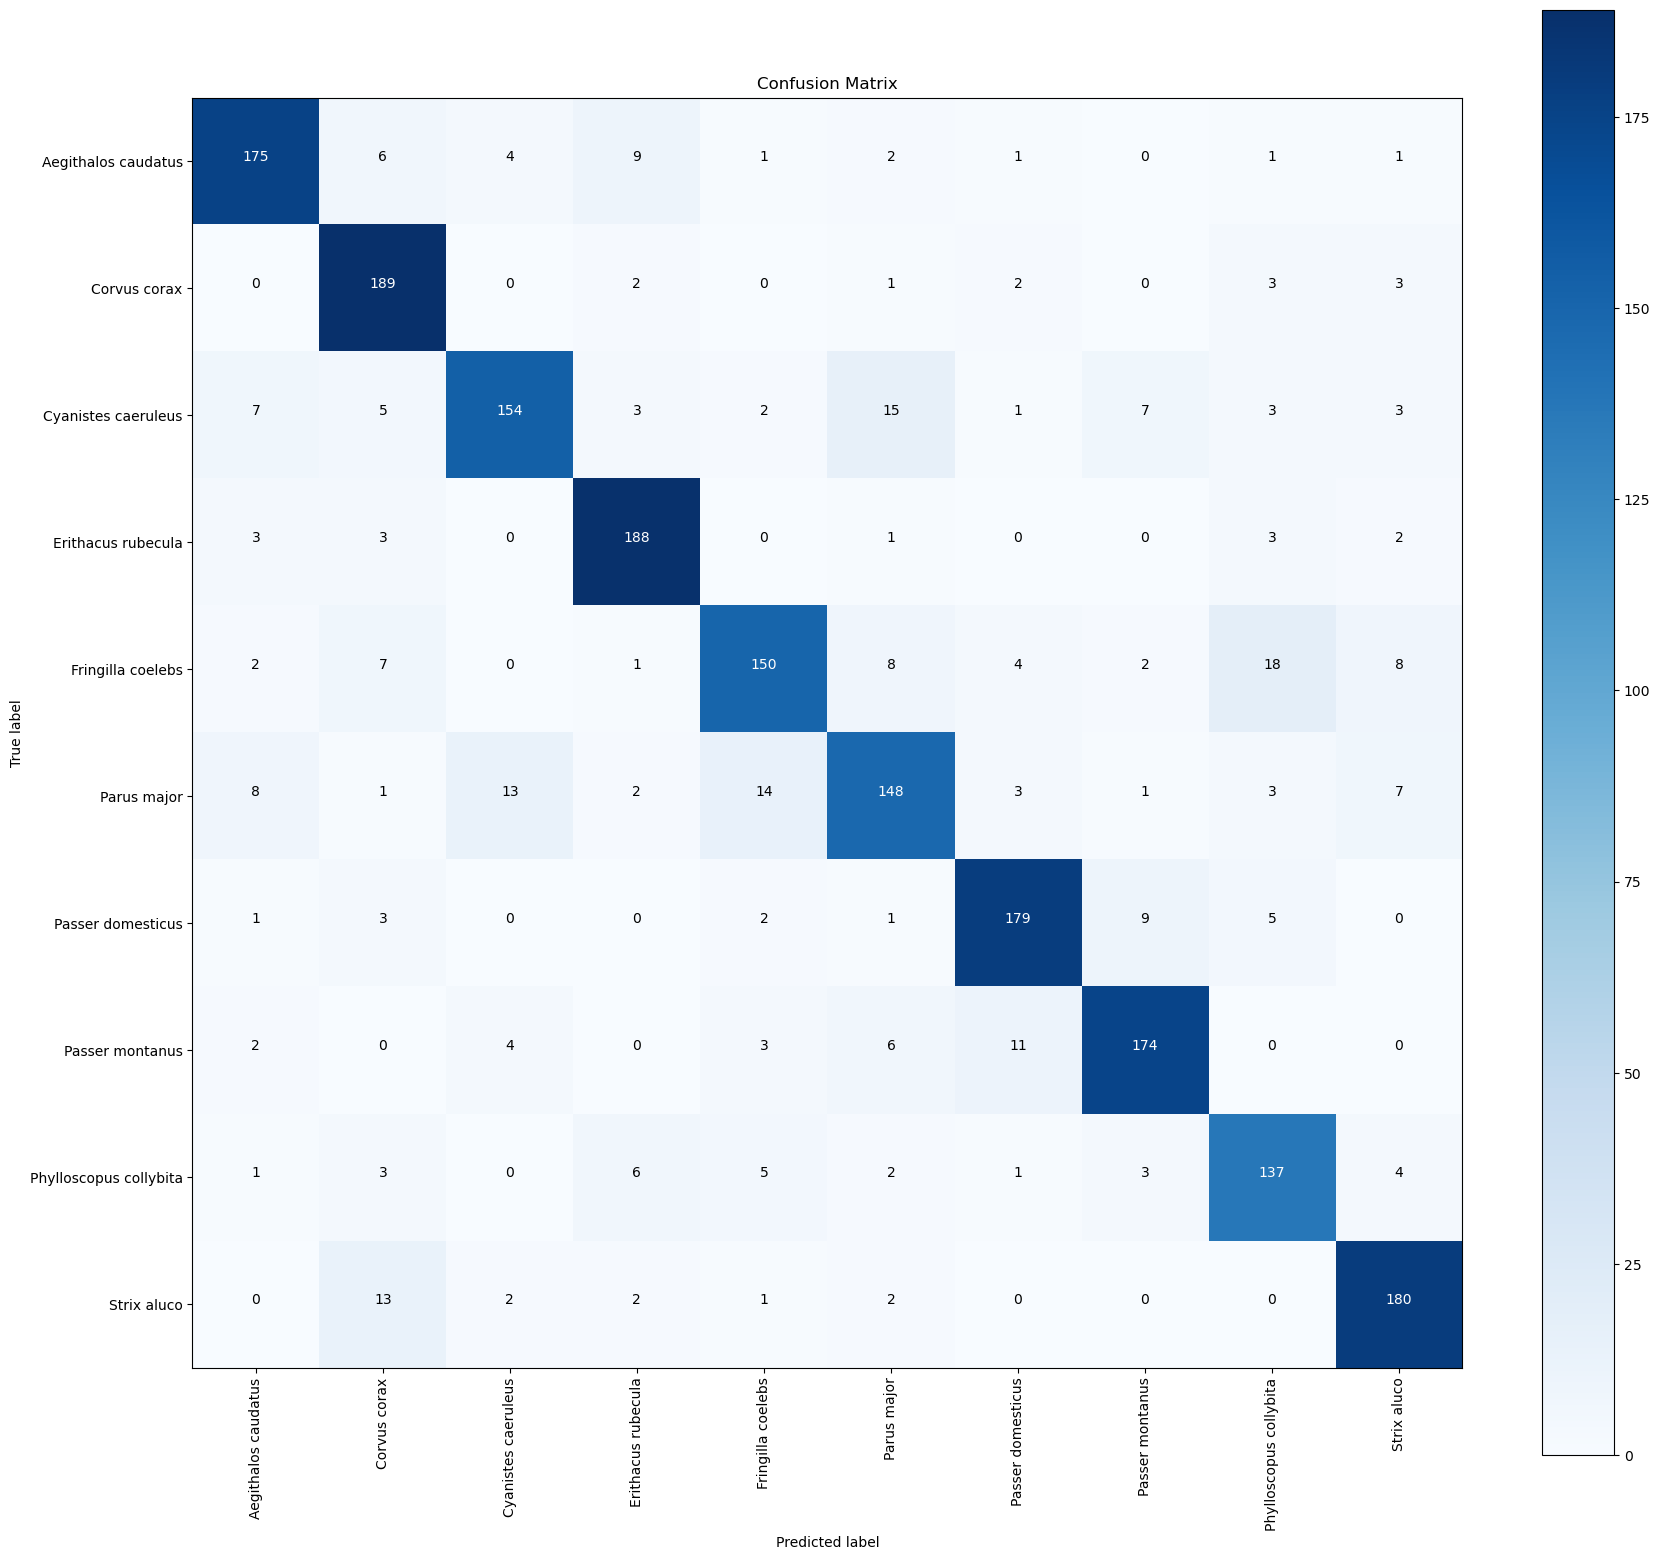


Classification report:

                        precision    recall  f1-score   support

   Aegithalos caudatus     0.8794    0.8750    0.8772       200
          Corvus corax     0.8217    0.9450    0.8791       200
   Cyanistes caeruleus     0.8701    0.7700    0.8170       200
    Erithacus rubecula     0.8826    0.9400    0.9104       200
     Fringilla coelebs     0.8427    0.7500    0.7937       200
           Parus major     0.7957    0.7400    0.7668       200
     Passer domesticus     0.8861    0.8950    0.8905       200
       Passer montanus     0.8878    0.8700    0.8788       200
Phylloscopus collybita     0.7919    0.8457    0.8179       162
           Strix aluco     0.8654    0.9000    0.8824       200

              accuracy                         0.8532      1962
             macro avg     0.8523    0.8531    0.8514      1962
          weighted avg     0.8535    0.8532    0.8520      1962



In [23]:
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8), is_norm=True):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)
    
    
    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    if is_norm:
        fmt = '.3f'
    else:
        fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a relatively small number of labels
if len(labels_list) <= 120:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred) # normalize='true'

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(18, 16), is_norm=False)

# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [24]:
end_time = time.time()  # Record the end time
total_time = end_time - start_time
print(f"Total runtime of the notebook: {total_time} seconds")

Total runtime of the notebook: 22545.026383638382 seconds


Weighted average f1 score of the best transfer learning model is 0.8514 which is sufficient for our purposes for 10 species bird sound classification. From confusion matrix, we can see a strong diagonal correct classification pattern. It is notable that missclassification is not uniform across the board. Fringilla coelebs was mistakenly classified as Phylloscopus collybita 18 times, with most other missclassifications between classes being significantly lower. While transfer learning model using Wav2Vec2 was the most successful model for our task, the training time was slightly over 6 hours. Therefore, when attempting to improve further on this model, desired accuracy needs to be weighted against resource consumption. 